<a href="https://www.kaggle.com/code/aryamanrao/dl-ecg-b-tech-project-mit-bih?scriptVersionId=164376596" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

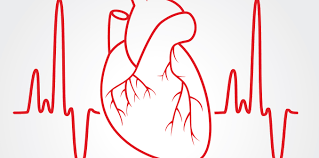


# **INTRODUCTION**

The MIT-BIH Arrhythmia Database contains 48 half-hour excerpts of two-channel ambulatory ECG recordings, obtained from 47 subjects studied by the BIH Arrhythmia Laboratory between 1975 and 1979. Twenty-three recordings were chosen at random from a set of 4000 24-hour ambulatory ECG recordings collected from a mixed population of inpatients (about 60%) and outpatients (about 40%) at Boston's Beth Israel Hospital; the remaining 25 recordings were selected from the same set to include less common but clinically significant arrhythmias that would not be well-represented in a small random sample.
souces : https://physionet.org/content/mitdb/1.0.0/


Arrhythmia Dataset

    Number of Samples: 109446
    Number of Categories: 5
    Sampling Frequency: 125Hz
    Data Source: Physionet's MIT-BIH Arrhythmia Dataset
    Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]


-N : Non-ecotic beats (normal beat)
-S : Supraventricular ectopic beats
-V : Ventricular ectopic beats
-F : Fusion Beats
-Q : Unknown Beats

**What is an ecg? **

An electrocardiogram (ECG) is a simple test that can be used to check your heart's rhythm and electrical activity.

Sensors attached to the skin are used to detect the electrical signals produced by your heart each time it beats.

These signals are recorded by a machine and are looked at by a doctor to see if they're unusual.

An ECG may be requested by a heart specialist (cardiologist) or any doctor who thinks you might have a problem with your heart, including your GP.
That's the result of this test we will analyze. 

**Load Data**

In [15]:
!pip install wandb --upgrade --quiet

In [16]:
import wandb
from wandb.keras import WandbCallback
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient() 

personal_key_for_api = user_secrets.get_secret("wandb-key")

! wandb login $personal_key_for_api

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
#from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

In [19]:
train_df = pd.read_csv('/kaggle/input/mitbih_train.csv',header=None)
test_df = pd.read_csv('/kaggle/input/mitbih_test.csv',header=None)

print(train_df.shape)
print(test_df.shape)

train_df[187]=train_df[187].astype(int) #Labels
equilibre=train_df[187].value_counts(sort = False)
print(equilibre)

(87554, 188)
(21892, 188)
187
0    72471
1     2223
2     5788
3      641
4     6431
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(10,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

We can underligned a huge difference in the balanced of the classes. After some try i have decided to  choose the resample technique more than the class weights for the algorithms. 

In [22]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=60000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=10000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=10000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=10000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=10000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [ ]:
equilibre1=train_df[187].value_counts(sort = False)
#print(equilibre)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre1, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
# The sum of the weights of all examples stays the same.
weights = []
for i in range(5):
    weights.append((1 / equilibre[i]) * (100000.0 / 5.0))

class_weight = dict(zip(range(5), weights))
print(class_weight)

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [23]:
target_train=train_df[187]
target_test=test_df[187]
y_train=target_train # to_categorical is one-hot encoding
y_test=target_test

X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values

''' No Noise '''
# for i in range(len(X_train)):
#     X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [24]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(100000, 186, 1) (21892, 186, 1)
(100000,) (21892,)


In [ ]:
sweep_configuration = {
    "method": "random",
    "name": "sweep",
    "metric": {"goal": "maximize", "name": "val_acc"},
    "parameters": {
        "batch_size": {"values": [16, 32, 64, 128, 256]},
        "epochs": {"values": [5, 10, 15, 20, 40]},
        "lr": {"max": 0.1, "min": 0.0001},
    },
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project="my-first-sweep")

In [25]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Shuffle and batch the dataset
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=len(X_test)).batch(batch_size)

In [ ]:
''' Pytorch Implementation '''
# import torch
# import torchvision
# import torchvision.transforms as transforms
# import torch.nn as nn
# import torch.nn.functional as F

# class Network(nn.Module):
#     def __init__(self):
#         super(Network, self).__init__()
#         self.conv1 = nn.Conv1d(1, 64, kernel_size = 6)
#         self.conv2 = nn.Conv1d(64, 64, kernel_size = 3)
#         self.conv3 = nn.Conv1d(64, 64, kernel_size = 3)
#         self.bn = nn.BatchNorm1d()
#         self.pool = nn.MaxPooling1d(3,2)#(kernel_size, stride)
#         self.fc1 = nn.Linear(64*3*3, 64)
#         self.fc2 = nn.linear(64, 32)
#         self.fc3 = nn.linear(32, 5)
        
#     def forward(self, x):
#         x = self.pool(self.bn(F.relu(self.conv1(x))))
#         x = self.pool(self.bn(F.relu(self.conv2(x))))
#         x = self.pool(self.bn(F.relu(self.conv3(x))))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
    
# import torch.optim as optim

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Model Implementation

In [26]:
def make_model():
    im_shape = (X_train.shape[1], 1)
    inputs_cnn = Input(shape=im_shape, name='inputs_cnn')
    
    # First convolutional layer (186,1)
    conv1_1 = Convolution1D(256, 6, activation='relu')(inputs_cnn)
    conv1_1 = BatchNormalization()(conv1_1)
    pool1 = MaxPool1D(pool_size=3, strides=2, padding="same")(conv1_1)
    dropout1 = Dropout(0.05)(pool1)
    
    # Second convolution block (181,128)
    def convolution_block(pool_input, filters):
        conv1 = Convolution1D(filters, 5, padding='same', kernel_regularizer=L2(0.1))(dropout1)
        lk1 = LeakyReLU(0.1)(conv1)
        bn1 = BatchNormalization()(lk1)
        conv2 = Convolution1D(filters, 5, padding='same', kernel_regularizer=L2(0.1))(bn1)
        lk2 = LeakyReLU(0.1)(conv2)
        bn2 = BatchNormalization()(lk2)
        #conv3 = Convolution1D(filters, 6, activation='relu', padding='same', kernel_regularizer=L2(0.1))(bn2)
        #bn3 = BatchNormalization()(conv3)
        return bn2
    
    conv21 = convolution_block(pool1, 64)
    conv22 = convolution_block(pool1, 64)
    conv23 = convolution_block(pool1, 64)
    
    combined_bn = tf.keras.layers.add([conv21, conv23, conv22])
    normalized_bn = Lambda(lambda x: tf.math.l2_normalize(x, axis=-1))(combined_bn)
    
    attention = MultiHeadAttention(num_heads=6, key_dim=6)(conv21, conv22, conv23)
    trial = tf.keras.layers.add([attention, normalized_bn])
    pool = MaxPool1D(pool_size=2, strides=2, padding="same")(trial)
    dropout = Dropout(0.10)(pool)
    
    # Third convolutional layer
    conv3_1 = Convolution1D(64, 3, activation='relu')(dropout)
    conv3_1 = BatchNormalization()(conv3_1)
    pool3 = MaxPool1D(pool_size=2, strides=2, padding="same")(conv3_1)
    dropout3 = Dropout(0.05)(pool3)
    
    # Fourth convolutional layer
    conv4_1 = Convolution1D(32, 3, activation='relu')(dropout3)
    conv4_1 = BatchNormalization()(conv4_1)
    pool5 = MaxPool1D(pool_size=2, strides=2, padding="same")(conv4_1)
    pool5 = Dropout(0.10)(pool5) #
    
    avg_pool = AveragePooling1D(pool_size = 2, strides = 2, padding="same")(conv4_1)
    pool5_1 = Dropout(0.10)(avg_pool)
    ''' Alias '''
    #gavg_pool = GlobalAveragePooling1D()(dropout4)
    
    # Fifth convolutional layer
    #conv5_1 = Convolution1D(32, 3, activation='relu')(pool4)
    #conv5_1 = BatchNormalization()(conv5_1)
    #dropout5 = Dropout(0.10)(conv5_1)
    #pool5 = MaxPool1D(pool_size=2, strides=2, padding="same")(dropout5)
    
    # Attention mechanism
    #attention = Attention()([pool5, pool5])
    attention1 = MultiHeadAttention(num_heads=6, key_dim=6)(pool5, pool5_1, (pool5+pool5_1)/2)
    attention2 = MultiHeadAttention(num_heads=3, key_dim=3)(pool5, pool5, pool5)
    
    summed_attention = tf.keras.layers.add([attention1, attention2])
    normalized_attention = Lambda(lambda x: tf.math.l2_normalize(x, axis=-1))(summed_attention)
    # Flatten and dense layers
    flatten = Flatten()(normalized_attention)
    #gavg_pool = GlobalAveragePooling1D()(normalized_attention)
    dense_end1 = Dense(64)(flatten)
    lr1 = LeakyReLU(0.1)(dense_end1)
    dense_end2 = Dense(32, activation='relu')(lr1)
    lr2 = LeakyReLU(0.1)(dense_end2)
    
    # Output layer
    main_output = Dense(5, activation='softmax', name='main_output')(lr2)

    model = Model(inputs= inputs_cnn, outputs=main_output)
    print(model.summary())
    return model

In [27]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [ ]:
# from keras.callbacks import Callback
# class LogBestAccuracy(Callback):
#     def __init__(self, run):
#         super(LogBestAccuracy, self).__init__()
#         self.run = run
#         self.best_accuracy = -float('inf')

#     def on_epoch_end(self, epoch, logs=None):
#         val_accuracy = logs.get('val_accuracy')
#         if val_accuracy is not None and val_accuracy > self.best_accuracy:
#             self.best_accuracy = val_accuracy
#             wandb.log({'best_accuracy': self.best_accuracy})

In [ ]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout, Attention, MultiHeadAttention, Lambda, LeakyReLU
from keras.layers import Input, AveragePooling1D
from keras.models import Model
from keras.layers import BatchNormalization
from keras.regularizers import L2
import keras
import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [48]:
def train(version):
    version = version
    config = {"learning_rate": 0.001, "epochs": 100,
        "batch_size": 256, "log_step": 200,
        "val_log_step": 50, "architecture": "CNN-Attention", "dataset": "MIT-BIH"}

    run = wandb.init(project='my-first-project', name=f"Model v{version}", config=config)
    config = wandb.config

    # Initialize model.
    model = make_model()
    optimizer = keras.optimizers.Adam(learning_rate=config.learning_rate)
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits = True)
    model.compile(optimizer, loss_fn ,metrics = ['accuracy'])

    callbacks = [EarlyStopping(monitor='val_accuracy', min_delta=0.0001, 
                               patience=18, verbose=0, mode='auto', baseline=None),
             ModelCheckpoint(filepath=f"/kaggle/working/best_model_{version}.h5", 
                             monitor='val_loss', save_best_only=True), 
                WandbCallback()]

    history = model.fit(X_train, y_train,epochs=config.epochs,
                      callbacks=callbacks, batch_size=config.batch_size,
                      validation_data=(X_test,y_test))

    run.finish()
    
    return model, history

In [32]:
model, history = train(48)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs_cnn (InputLayer)     [(None, 186, 1)]             0         []                            
                                                                                                  
                                                                                                  
                                                                                                  
 batch_normalization_18 (Ba  (None, 181, 256)             1024      ['conv1d_18[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_pooling1d_8 (MaxPoolin  (None, 91, 256)              0         ['batch_normalization_18

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240226_103158-ptpq7y6c/files/model-best)... Done. 0.0s


391/391 [==============================] - 36s 66ms/step - loss: 3.3710 - accuracy: 0.8667 - val_loss: 3.8564 - val_accuracy: 0.0661
Epoch 2/100
390/391 [============================>.] - ETA: 0s - loss: 0.3538 - accuracy: 0.9204

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240226_103158-ptpq7y6c/files/model-best)... Done. 0.0s


391/391 [==============================] - 24s 61ms/step - loss: 0.3537 - accuracy: 0.9204 - val_loss: 0.4284 - val_accuracy: 0.8866
Epoch 3/100
391/391 [==============================] - ETA: 0s - loss: 0.2913 - accuracy: 0.9330

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240226_103158-ptpq7y6c/files/model-best)... Done. 0.0s


391/391 [==============================] - 24s 61ms/step - loss: 0.2913 - accuracy: 0.9330 - val_loss: 0.3319 - val_accuracy: 0.9232
Epoch 4/100
391/391 [==============================] - 16s 40ms/step - loss: 0.2541 - accuracy: 0.9410 - val_loss: 0.4332 - val_accuracy: 0.8721
Epoch 5/100
391/391 [==============================] - 16s 40ms/step - loss: 0.2257 - accuracy: 0.9491 - val_loss: 0.9307 - val_accuracy: 0.6595
Epoch 6/100
391/391 [==============================] - ETA: 0s - loss: 0.2076 - accuracy: 0.9535

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240226_103158-ptpq7y6c/files/model-best)... Done. 0.0s


391/391 [==============================] - 23s 59ms/step - loss: 0.2076 - accuracy: 0.9535 - val_loss: 0.2355 - val_accuracy: 0.9521
Epoch 7/100
391/391 [==============================] - ETA: 0s - loss: 0.1937 - accuracy: 0.9581

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240226_103158-ptpq7y6c/files/model-best)... Done. 0.0s


391/391 [==============================] - 24s 61ms/step - loss: 0.1937 - accuracy: 0.9581 - val_loss: 0.2234 - val_accuracy: 0.9397
Epoch 8/100
391/391 [==============================] - ETA: 0s - loss: 0.1701 - accuracy: 0.9609

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240226_103158-ptpq7y6c/files/model-best)... Done. 0.0s


391/391 [==============================] - 24s 61ms/step - loss: 0.1701 - accuracy: 0.9609 - val_loss: 0.2045 - val_accuracy: 0.9570
Epoch 9/100
391/391 [==============================] - 15s 40ms/step - loss: 0.1674 - accuracy: 0.9634 - val_loss: 0.2385 - val_accuracy: 0.9400
Epoch 10/100
391/391 [==============================] - ETA: 0s - loss: 0.1538 - accuracy: 0.9661

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240226_103158-ptpq7y6c/files/model-best)... Done. 0.0s


391/391 [==============================] - 24s 61ms/step - loss: 0.1538 - accuracy: 0.9661 - val_loss: 0.1358 - val_accuracy: 0.9720
Epoch 11/100
391/391 [==============================] - 15s 40ms/step - loss: 0.1507 - accuracy: 0.9669 - val_loss: 0.2252 - val_accuracy: 0.9445
Epoch 12/100
391/391 [==============================] - 16s 40ms/step - loss: 0.1352 - accuracy: 0.9699 - val_loss: 0.1511 - val_accuracy: 0.9708
Epoch 13/100
391/391 [==============================] - 15s 40ms/step - loss: 0.1308 - accuracy: 0.9713 - val_loss: 0.1757 - val_accuracy: 0.9583
Epoch 14/100
391/391 [==============================] - 16s 40ms/step - loss: 0.1277 - accuracy: 0.9718 - val_loss: 0.1929 - val_accuracy: 0.9534
Epoch 15/100
391/391 [==============================] - 16s 40ms/step - loss: 0.1174 - accuracy: 0.9736 - val_loss: 0.1455 - val_accuracy: 0.9647
Epoch 16/100
391/391 [==============================] - 16s 40ms/step - loss: 0.1157 - accuracy: 0.9749 - val_loss: 0.1397 - val_accuracy

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240226_103158-ptpq7y6c/files/model-best)... Done. 0.0s


391/391 [==============================] - 23s 59ms/step - loss: 0.1058 - accuracy: 0.9761 - val_loss: 0.1320 - val_accuracy: 0.9718
Epoch 18/100
391/391 [==============================] - 16s 40ms/step - loss: 0.1046 - accuracy: 0.9766 - val_loss: 0.2048 - val_accuracy: 0.9500
Epoch 19/100
391/391 [==============================] - ETA: 0s - loss: 0.1046 - accuracy: 0.9770

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240226_103158-ptpq7y6c/files/model-best)... Done. 0.0s


391/391 [==============================] - 24s 61ms/step - loss: 0.1046 - accuracy: 0.9770 - val_loss: 0.1153 - val_accuracy: 0.9733
Epoch 20/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0991 - accuracy: 0.9777 - val_loss: 0.1233 - val_accuracy: 0.9751
Epoch 21/100
391/391 [==============================] - ETA: 0s - loss: 0.1020 - accuracy: 0.9778

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240226_103158-ptpq7y6c/files/model-best)... Done. 0.0s


391/391 [==============================] - 24s 61ms/step - loss: 0.1020 - accuracy: 0.9778 - val_loss: 0.1124 - val_accuracy: 0.9744
Epoch 22/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0907 - accuracy: 0.9799 - val_loss: 0.1212 - val_accuracy: 0.9747
Epoch 23/100
391/391 [==============================] - 15s 40ms/step - loss: 0.0912 - accuracy: 0.9797 - val_loss: 0.1188 - val_accuracy: 0.9728
Epoch 24/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0854 - accuracy: 0.9816 - val_loss: 0.2492 - val_accuracy: 0.9387
Epoch 25/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0885 - accuracy: 0.9808 - val_loss: 0.1335 - val_accuracy: 0.9717
Epoch 26/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0870 - accuracy: 0.9815 - val_loss: 0.2049 - val_accuracy: 0.9496
Epoch 27/100
391/391 [==============================] - ETA: 0s - loss: 0.0861 - accuracy: 0.9813

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240226_103158-ptpq7y6c/files/model-best)... Done. 0.0s


391/391 [==============================] - 24s 61ms/step - loss: 0.0861 - accuracy: 0.9813 - val_loss: 0.0988 - val_accuracy: 0.9820
Epoch 28/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0782 - accuracy: 0.9828 - val_loss: 0.1306 - val_accuracy: 0.9702
Epoch 29/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0758 - accuracy: 0.9831 - val_loss: 0.1049 - val_accuracy: 0.9783
Epoch 30/100
391/391 [==============================] - ETA: 0s - loss: 0.0756 - accuracy: 0.9832

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240226_103158-ptpq7y6c/files/model-best)... Done. 0.0s


391/391 [==============================] - 23s 60ms/step - loss: 0.0756 - accuracy: 0.9832 - val_loss: 0.0948 - val_accuracy: 0.9786
Epoch 31/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0717 - accuracy: 0.9842 - val_loss: 0.1129 - val_accuracy: 0.9789
Epoch 32/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0744 - accuracy: 0.9840 - val_loss: 0.1066 - val_accuracy: 0.9763
Epoch 33/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0714 - accuracy: 0.9845 - val_loss: 0.1017 - val_accuracy: 0.9794
Epoch 34/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0734 - accuracy: 0.9843 - val_loss: 0.1180 - val_accuracy: 0.9713
Epoch 35/100
391/391 [==============================] - 15s 40ms/step - loss: 0.0652 - accuracy: 0.9847 - val_loss: 0.0982 - val_accuracy: 0.9789
Epoch 36/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0653 - accuracy: 0.9853 - val_loss: 0.0978 - val_accuracy

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240226_103158-ptpq7y6c/files/model-best)... Done. 0.0s


391/391 [==============================] - 24s 61ms/step - loss: 0.0665 - accuracy: 0.9854 - val_loss: 0.0939 - val_accuracy: 0.9784
Epoch 39/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0650 - accuracy: 0.9854 - val_loss: 0.1092 - val_accuracy: 0.9762
Epoch 40/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0611 - accuracy: 0.9861 - val_loss: 0.1313 - val_accuracy: 0.9673
Epoch 41/100
391/391 [==============================] - 15s 40ms/step - loss: 0.0636 - accuracy: 0.9855 - val_loss: 0.1205 - val_accuracy: 0.9746
Epoch 42/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0622 - accuracy: 0.9862 - val_loss: 0.1013 - val_accuracy: 0.9772
Epoch 43/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0618 - accuracy: 0.9862 - val_loss: 0.1357 - val_accuracy: 0.9659
Epoch 44/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0617 - accuracy: 0.9864 - val_loss: 0.1210 - val_accuracy

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240226_103158-ptpq7y6c/files/model-best)... Done. 0.0s


391/391 [==============================] - 24s 62ms/step - loss: 0.0596 - accuracy: 0.9867 - val_loss: 0.0886 - val_accuracy: 0.9826
Epoch 46/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0602 - accuracy: 0.9865 - val_loss: 0.1483 - val_accuracy: 0.9681
Epoch 47/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0549 - accuracy: 0.9872 - val_loss: 0.0931 - val_accuracy: 0.9775
Epoch 48/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0576 - accuracy: 0.9874 - val_loss: 0.0933 - val_accuracy: 0.9783
Epoch 49/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0537 - accuracy: 0.9876 - val_loss: 0.1017 - val_accuracy: 0.9773
Epoch 50/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0546 - accuracy: 0.9872 - val_loss: 0.1015 - val_accuracy: 0.9772
Epoch 51/100
391/391 [==============================] - 15s 40ms/step - loss: 0.0562 - accuracy: 0.9877 - val_loss: 0.0912 - val_accuracy

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240226_103158-ptpq7y6c/files/model-best)... Done. 0.0s


391/391 [==============================] - 24s 61ms/step - loss: 0.0494 - accuracy: 0.9882 - val_loss: 0.0863 - val_accuracy: 0.9827
Epoch 55/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0537 - accuracy: 0.9880 - val_loss: 0.1096 - val_accuracy: 0.9754
Epoch 56/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0555 - accuracy: 0.9881 - val_loss: 0.0927 - val_accuracy: 0.9804
Epoch 57/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0513 - accuracy: 0.9890 - val_loss: 0.0928 - val_accuracy: 0.9830
Epoch 58/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0512 - accuracy: 0.9886 - val_loss: 0.1386 - val_accuracy: 0.9676
Epoch 59/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0512 - accuracy: 0.9880 - val_loss: 0.1399 - val_accuracy: 0.9723
Epoch 60/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0507 - accuracy: 0.9886 - val_loss: 0.0913 - val_accuracy

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240226_103158-ptpq7y6c/files/model-best)... Done. 0.0s


391/391 [==============================] - 23s 59ms/step - loss: 0.0528 - accuracy: 0.9891 - val_loss: 0.0856 - val_accuracy: 0.9841
Epoch 63/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0506 - accuracy: 0.9884 - val_loss: 0.0931 - val_accuracy: 0.9820
Epoch 64/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0458 - accuracy: 0.9896 - val_loss: 0.0912 - val_accuracy: 0.9815
Epoch 65/100
391/391 [==============================] - 15s 40ms/step - loss: 0.0468 - accuracy: 0.9889 - val_loss: 0.1267 - val_accuracy: 0.9720
Epoch 66/100
391/391 [==============================] - 15s 40ms/step - loss: 0.0510 - accuracy: 0.9884 - val_loss: 0.0899 - val_accuracy: 0.9821
Epoch 67/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0464 - accuracy: 0.9891 - val_loss: 0.1122 - val_accuracy: 0.9778
Epoch 68/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0516 - accuracy: 0.9890 - val_loss: 0.4834 - val_accuracy

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240226_103158-ptpq7y6c/files/model-best)... Done. 0.0s


391/391 [==============================] - 24s 61ms/step - loss: 0.0486 - accuracy: 0.9893 - val_loss: 0.0805 - val_accuracy: 0.9844
Epoch 75/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0435 - accuracy: 0.9906 - val_loss: 0.0920 - val_accuracy: 0.9819
Epoch 76/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0466 - accuracy: 0.9898 - val_loss: 0.0882 - val_accuracy: 0.9807
Epoch 77/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0472 - accuracy: 0.9897 - val_loss: 0.0884 - val_accuracy: 0.9839
Epoch 78/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0414 - accuracy: 0.9905 - val_loss: 0.0862 - val_accuracy: 0.9845
Epoch 79/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0422 - accuracy: 0.9903 - val_loss: 0.1073 - val_accuracy: 0.9779
Epoch 80/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0419 - accuracy: 0.9904 - val_loss: 0.0884 - val_accuracy

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240226_103158-ptpq7y6c/files/model-best)... Done. 0.0s


391/391 [==============================] - 24s 61ms/step - loss: 0.0414 - accuracy: 0.9908 - val_loss: 0.0800 - val_accuracy: 0.9837
Epoch 99/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0389 - accuracy: 0.9913 - val_loss: 0.1218 - val_accuracy: 0.9750
Epoch 100/100
391/391 [==============================] - 16s 40ms/step - loss: 0.0398 - accuracy: 0.9909 - val_loss: 0.0895 - val_accuracy: 0.9819


accuracy,▁▅▆▆▇▇▇▇▇▇▇█████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁███████████████████████████████████████
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.99088
best_epoch,97
best_val_loss,0.08002
epoch,99
loss,0.03977
val_accuracy,0.98191


In [ ]:
wandb.agent(sweep_id, function = train, count = 5)

Accuracy: 98.19%


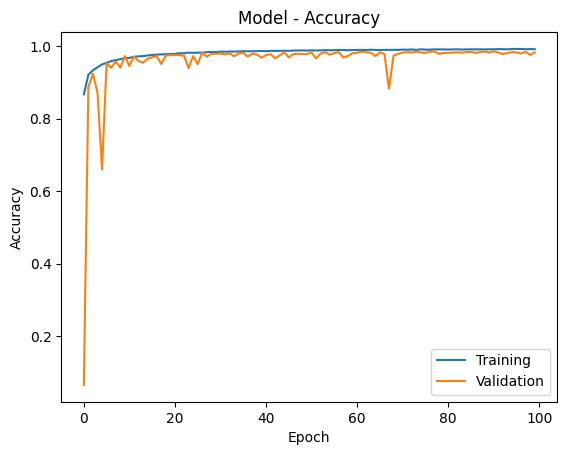

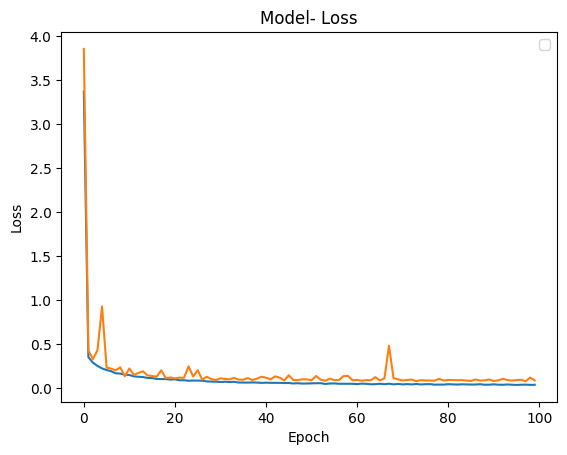

685/685 [==============================] - 3s 4ms/step


In [40]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

i take the next function from : https://www.kaggle.com/coni57/model-from-arxiv-1805-00794

Normalized confusion matrix

Confusion matrix, without normalization


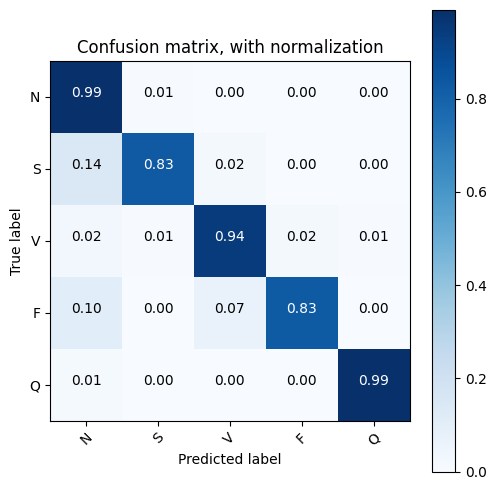

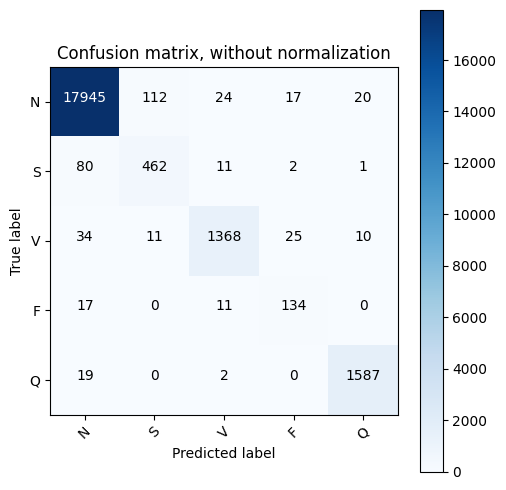

In [41]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
print()
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=False,
                      title='Confusion matrix, without normalization')
plt.show()



We underlign that two class(supraventricular and fusion) is weeker than the other. maybe due to less exemple in the starter dataset. I will try to improve in the next version.

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     18118
         1.0       0.79      0.83      0.81       556
         2.0       0.97      0.94      0.96      1448
         3.0       0.75      0.83      0.79       162
         4.0       0.98      0.99      0.98      1608

    accuracy                           0.98     21892
   macro avg       0.90      0.92      0.91     21892
weighted avg       0.98      0.98      0.98     21892



In [ ]:
y_pred[0]

In [43]:
from sklearn.preprocessing import label_binarize
y_binary = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

In [44]:
y_binary

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]])

In [45]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# ROC Curve for Multi-classification

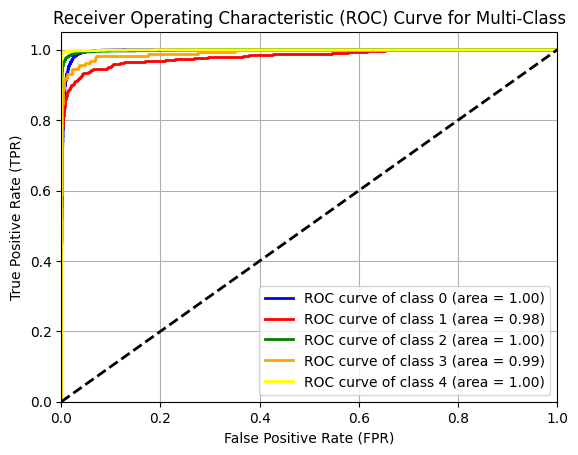

In [46]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_binary[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = cycle(['blue', 'red', 'green', 'orange', 'yellow'])
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ROC AUC Curve

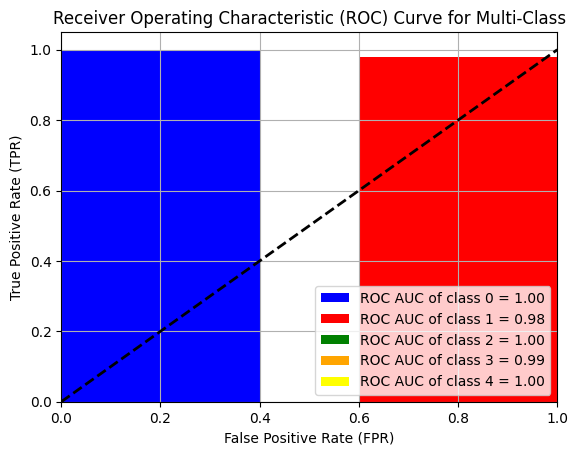

In [47]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_binary[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = cycle(['blue', 'red', 'green', 'orange', 'yellow'])
for i, color in zip(range(5), colors):
    plt.bar(i, roc_auc[i], color=color, label='ROC AUC of class {0} = {1:0.2f}'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()